# Fourier Modes in Galactic Disks

## General Mathematical Formulation

The azimuthal distribution of stellar mass (or surface density) in a galactic disk can be decomposed into Fourier modes:


#### $\Sigma(r, \theta) = \sum_{m=0}^{\infty} B_m(r) \cos\left[m\theta - \phi_m(r)\right]$


- $m$ is the mode number ($m=0$ is axisymmetric, $m=1$ is lopsided, $m=2$ is bar-like, etc.)
- $B_m(r)$ is the amplitude of mode $m$ at radius $r$
- $\phi_m(r)$ is the phase angle of mode $m$ at radius $r$

---

## Complex Formulation

The decomposition can also be written using complex exponentials:


#### $\Sigma(r, \theta) = \sum_{m=0}^{\infty} \left[ X_c(r) \cos(m\theta) + Y_s(r) \sin(m\theta) \right]$


or equivalently,


#### $\Sigma(r, \theta) = \sum_{m=0}^{\infty} \mathrm{Re}\left[ C_m(r) e^{im\theta} \right]$

where $C_m(r) = X_c(r) - i Y_s(r)$.

In the code we use this term as: $C_m(r_j) = \sum_{m=0}^{\infty}  M_j e^{-im\theta} $

Where $M_j$ is the total mass of a radial annulus

---

## Computing Amplitudes and Phases

For $N$ particles in an annulus at radius $r$, with masses $m_j$ and azimuthal angles $\theta_j$:

- **Cosine coefficient:**
 
  $X_c(r) = \sum_{j=1}^{N} m_j \cos(m\theta_j)$

- **Sine coefficient:**

  $Y_s(r) = \sum_{j=1}^{N} m_j \sin(m\theta_j)$


The **amplitude** $B_m(r)$ and **phase angle** $\phi_m(r)$ are:


$B_m(r) = \sqrt{X_c(r)^2 + Y_s(r)^2}$


$\phi_m(r) = \arctan2(Y_s(r), X_c(r))$


The **normalized amplitude** $A_m(r)$ is:


$A_m(r) = \frac{B_m(r)}{B_0(r)}$

where $B_0(r)$ is the total mass in the annulus.

---

## Example Illustration

![Fourier Modes Example](fourier_modes.png)

*Figure: Schematic representation of Fourier modes in a galactic disk.*

---

## References

- Rix & Zaritsky (1995)
- Zaritsky et al. (2013)

---
# How use the Fourier Mode code (FourierLib)?

This code is tailored for a face-on disc galaxy. It is based on the distribution of stellar/gas particles from a hydrodynamic simulation. When working with observational data, however, you can use pixels in an image as a proxy for these fictitious particles.

First we copy/paste the FourierLib.py in the same folder of your work code. Then we import the code as a Library

In [1]:
import FourierLib as fm

We open other important libraries used for this analisys

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

Then load the data of the FITS file using astropy

In [3]:
filepath='M101.fits'
# Open the FITS file
hdul = fits.open(filepath)

# Print info about the HDUs
hdul.info()

# Access the primary data (usually an image or table)
data = hdul[0].data
header = hdul[0].header
image_data = data[1, :, :]

Filename: M101.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (1200, 900, 4)   uint8   


In order to visualise our data, so that we can verify that it corresponds to the objects we intend to analyse.

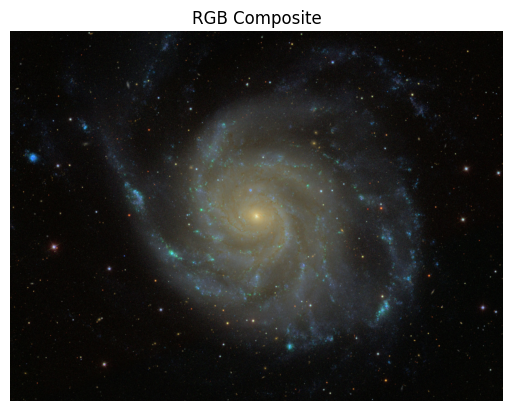

In [4]:
fm.show_rgb(data)

## Data Preparation for Fourier Analysis

Observational data (image pixels) need to be converted to a format compatible with the FourierLib library, which expects data as if they were particles from a simulation.

### Steps:
1. **Create fictitious particles**: Each pixel is treated as a particle with coordinates (x, y, z) corresponding to its position in the image and m corresponding to its brightness (intensity).
2. **Centering coordinates**: Adjust the (x, y) coordinates so that the galaxy's center is at (0, 0). This is typically done by subtracting half the image dimensions from the pixel coordinates.
3. **Create fictitious velocities**: Since we work with observational data, velocities are set to zero.
4. **Build particle array**: Format [x, y, z, vx, vy, vz, mass] where mass = pixel brightness

In [5]:
x, y, z, m = fm.Img2Cart(image_data)
x,y = x - (x.max()*0.5), y-(y.max()*0.5)

In [8]:
# Crear vectores de velocidad ficticios (todos cero para datos observacionales)
vx = np.zeros_like(x)
vy = np.zeros_like(y)
vz = np.zeros_like(z)

# Construir el array de datos estelares en formato requerido por FourierLib
# Cada fila representa una "partícula" con [x, y, z, vx, vy, vz, masa/brillo]
data_star = np.array([x, y, z, vx, vy, vz, m]).T

print(f"Datos preparados: {data_star.shape[0]} píxeles convertidos a 'partículas'")
print(f"Rango X: [{x.min():.1f}, {x.max():.1f}]")
print(f"Rango Y: [{y.min():.1f}, {y.max():.1f}]")
print(f"Rango de brillo: [{m.min():.1f}, {m.max():.1f}]")

Datos preparados: 1080000 píxeles convertidos a 'partículas'
Rango X: [-599.5, 599.5]
Rango Y: [-449.5, 449.5]
Rango de brillo: [0.0, 252.0]


## Parameters Configuration

Before executing the Fourier mode analysis, we need to define the key parameters:

- **Ropt**: Optical radius reference (in pixels)
- **r_min, r_max**: Radial range of analysis (in Ropt units)
- **grid_size**: Output grid resolution
- **n_radios**: Number of radial rings for calculation
- **modes**: List of Fourier modes to calculate (m=0: axisymmetric, m=1: lopsided, m=2: bar, etc.)

In [9]:
# Instanciar la clase Asymmetry con los datos preparados
g = fm.Asymmetry(data_star)

# Definir parámetros del análisis
Ropt = 300  # Radio óptico de referencia (en píxeles)
r_min = 0   # Radio interno (en unidades de Ropt)
r_max = 1.5 # Radio externo (en unidades de Ropt)
grid_size = 300  # Resolución de la grilla de salida
n_radios = 100   # Número de anillos radiales para el cálculo
modes = [0, 1, 2, 3, 4, 5]  # Modos de Fourier a calcular

print(f"Parámetros configurados:")
print(f"  Radio óptico: {Ropt} píxeles")
print(f"  Rango radial: {r_min} - {r_max} Ropt ({r_min*Ropt} - {r_max*Ropt} píxeles)")
print(f"  Resolución: {grid_size}x{grid_size}")
print(f"  Anillos radiales: {n_radios}")
print(f"  Modos a calcular: {modes}")

Parámetros configurados:
  Radio óptico: 300 píxeles
  Rango radial: 0 - 1.5 Ropt (0 - 450.0 píxeles)
  Resolución: 300x300
  Anillos radiales: 100
  Modos a calcular: [0, 1, 2, 3, 4, 5]


## Fourier Mode Analysis Execution

Now we execute the main analysis using the `Mfourier2D_v2` method, which:

1. **Divides the galaxy into radial rings** from r_min to r_max
2. **Calculates Fourier coefficients** in each ring for each mode m
3. **Radially interpolates** coefficients to create continuous 2D maps
4. **Normalizes** by total mass in each ring (if normalize=True)

**Result**: Dictionary of 2D maps, one for each requested Fourier mode.

In [10]:
# Ejecutar el análisis de modos de Fourier 2D
Mf, Xc, Yc = g.Mfourier2D_v2(Ropt, r_min=r_min, r_max=r_max,
                              grid_size=grid_size, n_radios=n_radios, 
                              modes=modes, normalize=True)

print(f"Modos calculados: {list(Mf.keys())}")
print(f"Dimensiones de cada mapa: {Mf[1].shape}")
print(f"Rango X: [{Xc[0]:.1f}, {Xc[-1]:.1f}] píxeles")
print(f"Rango Y: [{Yc[0]:.1f}, {Yc[-1]:.1f}] píxeles")

Modos calculados: [0, 1, 2, 3, 4, 5]
Dimensiones de cada mapa: (300, 300)
Rango X: [-450.0, 450.0] píxeles
Rango Y: [-450.0, 450.0] píxeles


## Results Visualization

We create a comparative visualization with two panels:

### Left Panel: Fourier Mode m=1 (Lopsidedness)
- Shows the 2D map of mode m=1 that detects asymmetric or "lopsided" structures
- Colormap: blue = negative amplitudes, red = positive amplitudes
- Coordinates in pixels converted to the analysis reference system

### Right Panel: Original Image with Analysis Region  
- Original FITS image of the galaxy
- Overlaid circles showing exactly which region was analyzed

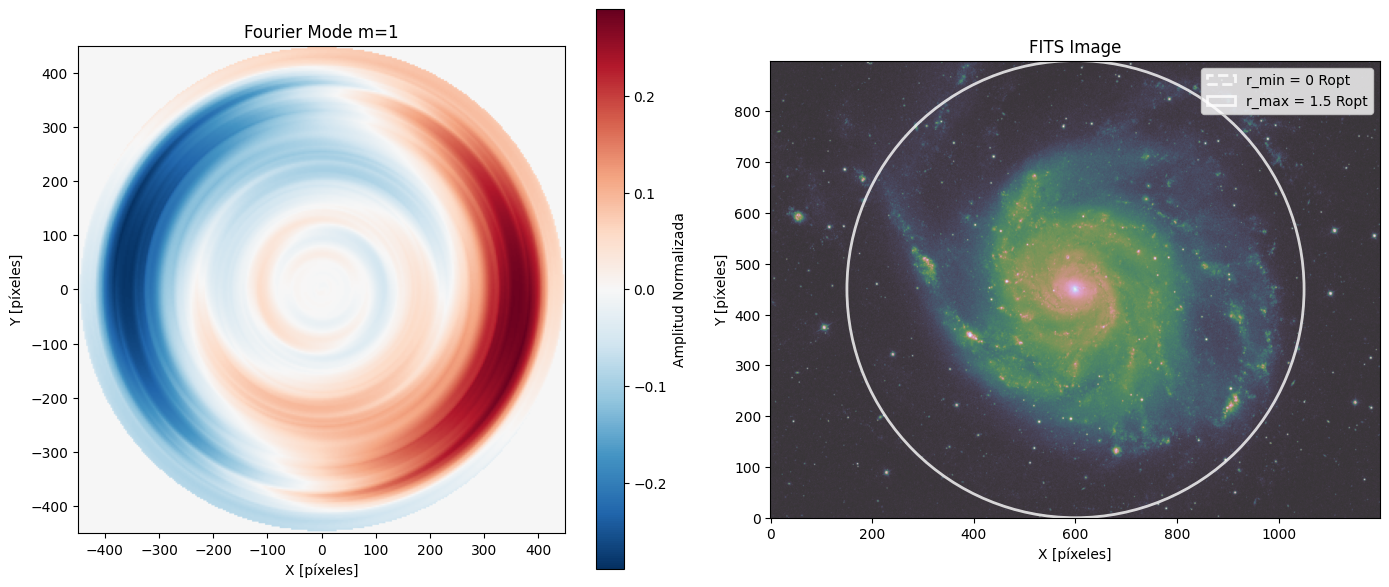

Región analizada:
  Radio interno: 0 píxeles
  Radio externo: 450 píxeles
  Área analizada: 636173 píxeles²


In [12]:
# Crear subplot con dos paneles para comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Panel izquierdo: Modo de Fourier m=1 (índice 1 en el diccionario)
im1 = ax1.imshow(Mf[1].T, extent=[Xc[0], Xc[-1], Yc[0], Yc[-1]], 
                 origin='lower', cmap='RdBu_r')
ax1.set_title('Fourier Mode m=1')
ax1.set_xlabel('X [píxeles]')
ax1.set_ylabel('Y [píxeles]')
plt.colorbar(im1, ax=ax1, label='Amplitud Normalizada')

# Panel derecho: Imagen original con región de análisis
ax2.imshow(image_data, origin='lower', cmap='cubehelix', alpha=0.8)
ax2.set_title('FITS Image')
ax2.set_xlabel('X [píxeles]')
ax2.set_ylabel('Y [píxeles]')

# Calcular y dibujar círculos de la región de análisis
center_x, center_y = image_data.shape[1] / 2, image_data.shape[0] / 2
r_min_pixels = (r_min * Ropt) 
r_max_pixels = (r_max * Ropt)

# Círculos indicando la región analizada
circle_inner = plt.Circle((center_x, center_y), r_min_pixels, 
                         fill=False, color='white', linewidth=2, 
                         linestyle='--', alpha=0.8, label=f'r_min = {r_min} Ropt')
circle_outer = plt.Circle((center_x, center_y), r_max_pixels, 
                         fill=False, color='white', linewidth=2, 
                         linestyle='-', alpha=0.8, label=f'r_max = {r_max} Ropt')
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Región analizada:")
print(f"  Radio interno: {r_min_pixels:.0f} píxeles")
print(f"  Radio externo: {r_max_pixels:.0f} píxeles")
print(f"  Área analizada: {np.pi * (r_max_pixels**2 - r_min_pixels**2):.0f} píxeles²")